## Fitting ALMA CO(2-1) spectra in M87

I extracted a total spectrum using `casaviewer v4.6`, and saved it as a simple ASCII files. This ASCII file had columns of flux density in Jy, and km/s relative to `restfreq = 229.537` GHz, (i.e., CO(2-1) at ` z= `  ). The extracted spectra and their associated extraction regions are shown here:  

<img src="region.png">

Let's fit these spectra with gaussians, so as to better characterize the masses associated with each regional component. This solution requires Adam Ginsburg's [PySpecKit](http://pyspeckit.bitbucket.org/html/sphinx/index.html) which requires Python 2.7 (3.x won't work). 

In [1]:
import sys
import os
import glob

import numpy as np

from astropy.io import ascii
from astropy.table import QTable

from astropy.cosmology import FlatLambdaCDM

import astropy.units as u
from astropy import constants as const

import pyspeckit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

ModuleNotFoundError: No module named 'pyspeckit'

Make some units and a cosmology:

In [2]:
emission_integral_units_mJy = u.mJy * u.km / u.s
emission_integral_units_Jy = u.Jy * u.km / u.s

xco_unit = u.cm**(-2) * (u.K * u.km * u.s**(-1))**(-1)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### The redshift used in the creation of the cubes was:

In [71]:
restfreq = 229.537 * u.GHz
co21rest = 230.538 * u.GHz

z = 1 - (restfreq / co21rest)
z

<Quantity 0.004342017368069495>

In [72]:
cz = const.c.to(u.km / u.s) * z
cz

<Quantity 1301.7040594522446 km / s>

### The redshift used in Aurora's paper draft:

In [73]:
z_draft = 1307 * (u.km / u.s) / const.c.to(u.km / u.s)
z_draft

<Quantity 0.004359682724239848>

To conform to this, make the zero point: 

In [74]:
rest_aurora = co21rest / (1 + z_draft)
rest_aurora

<Quantity 229.53729024116677 GHz>

(note that the NED redshift for M87 is 0.004283)

## Make your plots pretty

This is best done globally, so that both my custom plotter \& Adam's PySpecKit plotter() output consistent plot styles. 

In [75]:
plt.rcParams.update({'font.size'     : 16,
                    'axes.labelsize' : 16,
                    'legend.fontsize': 16,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18,
                    'axes.linewidth' :  2 })

plt.rc('font', family='Helvetica')

## Functions

Make some simple i/o functions for these ascii files: 

In [76]:
def makeSpectrum(file):
    
    # Read the raw ASCII spectrum into an Astropy TABLE object
    rawdata = ascii.read(file)
    
    # Give the columns meaningful names
    if 'col1' in rawdata.columns:
        rawdata.rename_column('col1','Velocity')
    if 'col2' in rawdata.columns:
        rawdata.rename_column('col2', 'FluxDensity')
        
    # Give the new columns proper units. 
    # We'll have to strip them later, because PySpecKit doesn't 
    # like "quantity" objects, but it's useful to have the functionality
    # anyway
    Velocity = rawdata['Velocity'] * (u.km / u.s)
    FluxDensityJy = rawdata['FluxDensity'] * u.Jy

    # Put the flux into mJy 
    FluxDensity = FluxDensityJy.to(u.mJy)
    
    # Manually write the errors. The RMS of the 10 km/s cube
    # is 0.35 mJy / 10 km/s channel. This is the error on the flux.
    # The velocity channel width is +/- 5 km/s, e.g. 10 km/s width. 
    VelErr = ((np.zeros(len(Velocity))) + 5.0) * (u.km / u.s)
    FluxErr = ((np.zeros(len(FluxDensity))) + 0.35) * u.mJy

    # Construct the main Astropy TABLE with Units
    data = QTable([Velocity, FluxDensity, VelErr, FluxErr], names=("Velocity", "Flux Density", "Velocity Error", "Flux Error"))
    
    # Also constuct unit-free versions for passing to PySpecKit
    
    
    flux = FluxDensity.value
    vel = Velocity.value
    
    rms = FluxErr.value
    width = VelErr.value
    
    return data, vel, flux, width, rms

In [77]:
def specfit(vel, flux, rms, guesses=None, figname="fig.pdf"):
    
    sp = pyspeckit.Spectrum(data=flux, error=rms, xarr=vel, xarrkwargs={'unit':'km/s'}, unit='mJy')
    
    # If the user was too lazy to supply a guess, begrudgingly fit a single gaussian 
    # while attempting to pick an intelligent starting point
    if guesses is None:
        amplitude_guess = flux.max()
        center_guess = (flux * vel).sum() / flux.sum() # Try to guess the Gaussian center
        width_guess = flux.sum() / amplitude_guess / np.sqrt(2*np.pi)
        
        guesses = [amplitude_guess, center_guess, width_guess]
        
    
    sp.specfit.multifit(guesses=guesses, negamp=False, renormalize='auto')
    
    # Guesses should take the format of: 
    # guesses = [amplitude_guess, center_guess, width_guess]
    # Multiple components are strung along in one array, e.g. 
    # guesses = [5.,100.,100.,            where this is [amp, center, width] of Gaussian 1
    #           15., -20., 60.,           ... guassian 2
    #           2.5, -200., 20.]          ... gaussian 3 (and so on...)
    
    sp.plotter(errstyle='fill', xmin=-500, xmax=500, ymin=-5, ymax=20)
    sp.specfit.plot_components(add_baseline=False,component_yoffset=-0.2)
    sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0,label=False)
    sp.specfit.plot_fit(annotate=True, lw=2.0)
    sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.0,label=False, color='gray')
    
    #sp.specfit.annotate(chi2='optimal')
    
    # Note that this isn't the 'real' chi2! It's something Adam made up! 
    # It uses the fitted model to find all pixels that are above the noise in the spectrum
    # then computes chi^2/n using only those pixels
    
    #chi2 = sp.specfit.optimal_chi2(reduced=True)
    #print(chi2)
    
    components = sp.specfit.get_components()
    #print(components)
    
    # The integral will be in units of mJy * km/s
    integral, error = sp.specfit.integral(direct=True, return_error=True)
    
    mass, emission_integral = gasmass(integral, error)
    
    sp.plotter.savefig(figname)
    print("Saved this figure as %s" % figname)
    
    return components, mass, emission_integral
    
    #emcee_ensemble = sp.specfit.get_emcee()
    #p0 = emcee_ensemble.p0 * (np.random.randn(*emcee_ensemble.p0.shape) / 10. + 1.0)
    #pos,logprob,state = emcee_ensemble.run_mcmc(p0,100)
    
    #sp.specfit.get_components()
    


In [78]:
def gasmass(gaussian_area, gaussian_area_err):
    '''
    Compute a gas mass for M87. 
    The gaussian area must be in mJy * km/s (becuase I explicitly convert to Jy * km/s below)
    '''
    
    emission_integral = (gaussian_area * emission_integral_units_mJy).to(emission_integral_units_Jy)
    emission_integral_err = (gaussian_area_err * emission_integral_units_mJy).to(emission_integral_units_Jy)
    
    redshift = 0.0043596827 # Redshift of M87 used in Aurora's paper
    xco = 2.0e20 * xco_unit
    ratio = 3.2  # CO(2-1) to CO(1-0) flux density ratio
    
    xco_mw = 2.0e20 * xco_unit
    ldist = cosmo.luminosity_distance(redshift).to(u.Mpc)
    print(ldist)
    
    rawmass = 1.05e4 * (xco / xco_mw) * (1 + redshift)**(-1) * (emission_integral / emission_integral_units_Jy) * (ldist/u.Mpc)**2 * (1.0/ratio)
    
    finalmass = rawmass * u.M_sun
       
    return finalmass, emission_integral

In [79]:
def plotter(velocity, flux, width=None, rms=None, title="Remember to Set a Title!"):
    
    fig, ax = plt.subplots(1)
    
    if width is None and rms is None:
        component_number = np.shape(flux)[0]
        for i in range(component_number):
            ax.plot(velocity, flux[i], lw=2.0, color='blue')
    else: 
        ax.plot(velocity, flux, lw=0.5, color='black')
        ax.fill_between(velocity, flux+rms, flux-rms, facecolor='blue', alpha=0.5)
        #ax.fill_betweenx(flux, velocity+width, velocity-width, facecolor='blue', alpha=0.5)
        
    ax.set_xlim([-500,500])
    ax.set_ylim([-5, 20])
    
    ax.set_title(title)
    ax.set_xlabel('Velocity (km / s)')
    ax.set_ylabel('Flux density (mJy)')
    
    #plt.figure()
    #plt.errorbar(velocity, flux, xerr=width, yerr=rms, 
    #         marker='o', markersize=0.5, ls='-', color='black', elinewidth=2, capsize=0)

    #plt.title("CO(2-1) Line Profile")



### Fitting the 'Total' Region

In [80]:
glob.glob('*.txt')

['full_m87_aperture.txt']

In [81]:
glob.glob('*.txt')

totalfile = 'full_m87_aperture.txt'
totaldata, totalvel, totalflux, totalwidth, totalrms = makeSpectrum(totalfile)

18.7344105248 Mpc
Saved this figure as total_region.pdf


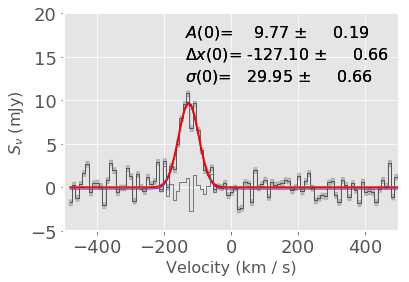

In [82]:
# Guesses go like:  Amplitude, Center, Width
    

totalguesses = [6., -130., 70.]

total_fit, total_mass, emission_integral = specfit(totalvel, totalflux, totalrms, totalguesses, "total_region.pdf")

For an emission integral of

In [83]:
emission_integral

<Quantity 0.741665888428566 Jy km / s>

The total mass (assuming a MW X$_{\mathrm{CO}}$) is: 

In [84]:
total_mass

<Quantity 850429.7024072045 solMass>

(This is consistent within errors with the mass we report in the paper - see my other notebook). The reason for the variation is that this particular gaussian fit is done to data with 10kms bins, which was not what we used in the other gas mass calculation notebook. Completely fine. (again, we're within errors). 